In [1]:
%pip install bayesian-optimization==1.4.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ab4322","key":"2e8854f5b46c4ed4d6f38f6ec2bee4a8"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 99% 147M/149M [00:06<00:00, 22.7MB/s]
100% 149M/149M [00:06<00:00, 22.7MB/s]


In [5]:
!unzip /content/brain-tumor-mri-dataset.zip -d /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/Dataset/Training/glioma/Tr-gl_0726.jpg  
  in

In [6]:
train_path = '/content/Dataset/Training'
test_path = '/content/Dataset/Testing'

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
train_images = train_datagen.flow_from_directory(train_path, batch_size = 32, target_size = (200, 200))

test_datagen = ImageDataGenerator(rescale = 1./255)
test_images = test_datagen.flow_from_directory(test_path, batch_size = 32, target_size = (200, 200))

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
train_y=train_images.classes
test_y=test_images.classes

In [9]:
test_y

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [10]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [11]:
from keras.layers import BatchNormalization
BatchNormalization(momentum=0.9)

from keras.layers import Dropout

In [13]:
from keras.layers import LeakyReLU, Activation
input_layer = Input((200, 200, 3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(4)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 200, 200, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                             

In [ ]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
trained = model.fit(train_images
          , epochs = 10
          , batch_size = 32
          , validation_data = test_images
          , callbacks = [checkpoint])

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.8051

179/179 [==============================] - 760s 4s/step - loss: 0.5482 - accuracy: 0.8051 - val_loss: 1.4166 - val_accuracy: 0.5721
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9202

179/179 [==============================] - 743s 4s/step - loss: 0.2293 - accuracy: 0.9202 - val_loss: 0.7550 - val_accuracy: 0.7178
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9659

179/179 [==============================] - 731s 4s/step - loss: 0.1042 - accuracy: 0.9659 - val_loss: 0.5867 - val_accuracy: 0.7841
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9821

179/179 [==============================] - 733s 4s/step - loss: 0.0638 - accuracy: 0.9821 - val_loss: 0.3002 - val_accuracy: 0.9016
Epoch 5/10
179/179 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9898

179/179 [==============================] - 763s 4s/step - loss: 0.0390 - accuracy: 0.9898 - val_loss: 0.2388 - val_accuracy: 0.9207
Epoch 6/10
179/179 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9933

179/179 [==============================] - 726s 4s/step - loss: 0.0298 - accuracy: 0.9933 - val_loss: 0.2020 - val_accuracy: 0.9405
Epoch 7/10
179/179 [==============================] - 762s 4s/step - loss: 0.0171 - accuracy: 0.9960 - val_loss: 0.2556 - val_accuracy: 0.9252
Epoch 8/10
179/179 [==============================] - 753s 4s/step - loss: 0.0137 - accuracy: 0.9977 - val_loss: 0.2162 - val_accuracy: 0.9397
Epoch 9/10
179/179 [==============================] - 757s 4s/step - loss: 0.0095 - accuracy: 0.9986 - val_loss: 0.2107 - val_accuracy: 0.9382
Epoch 10/10
179/179 [==============================] - 722s 4s/step - loss: 0.0142 - accuracy: 0.9975 - val_loss: 0.2303 - val_accuracy: 0.9390


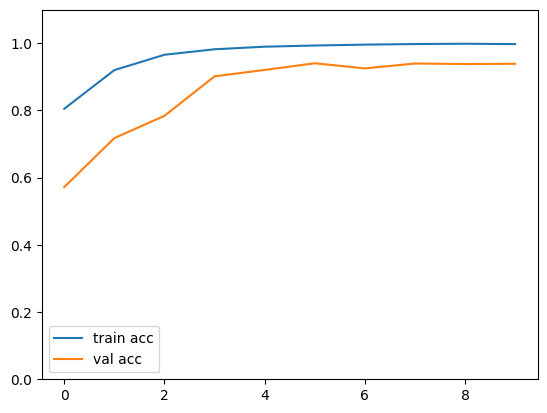

In [ ]:
plt.plot(trained.history['accuracy'], label='train acc')
plt.plot(trained.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('MRI-Dataset-Accuracy.png')
plt.ylim(top = 1.1, bottom = 0)
plt.show()

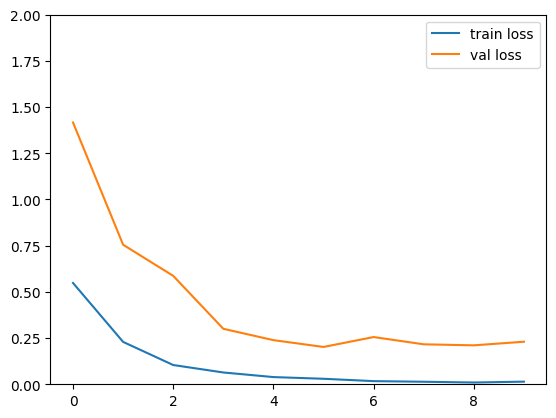

In [ ]:
plt.plot(trained.history['loss'], label='train loss')
plt.plot(trained.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('MRI-Dataset-Loss.png')
plt.ylim(top=2.0, bottom=0)
plt.show()

In [ ]:
model.evaluate(test_images, batch_size=32)

#Transfer Learning

In [14]:
from keras.applications.vgg16 import VGG16

pre_train = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
for layer in pre_train.layers:
    layer.trainable = False
x = pre_train(input_layer)

In [15]:
x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(4)(x)
output_layer = Activation('softmax')(x)

model2 = Model(input_layer, output_layer)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 32)          147488    
                                                                 
 batch_normalization_6 (Batc  (None, 6, 6, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6, 6, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 32)          9248      
                                                           

In [16]:
opt = Adam(learning_rate=0.0005)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [18]:
trained2 = model2.fit(train_images
          , epochs = 10
          , batch_size = 32
          , validation_data = test_images
          , callbacks = [checkpoint])

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.8321 

KeyboardInterrupt: ignored

In [19]:
plt.plot(trained2.history['accuracy'], label='train acc')
plt.plot(trained2.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('MRI-Dataset-Accuracy-2.png')
plt.ylim(top = 1.1, bottom = 0)
plt.show()

NameError: ignored

In [ ]:
plt.plot(trained2.history['loss'], label='train loss')
plt.plot(trained2.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('MRI-Dataset-Loss-2.png')
plt.ylim(top=2.0, bottom=0)
plt.show()

In [ ]:
model2.evaluate(test_images, batch_size=32)

#Confusion Matrix

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model2.predict(test_images)

In [ ]:
cm = confusion_matrix(test_y, np.argmax(y_pred, axis = 1))

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Glioma','Meningioma','No Tumor', 'Pituitary'], 
                     columns = ['Glioma','Meningioma','No Tumor', 'Pituitary'])

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()